# Exploratory Data Analysis & Probability

## Step 1: Load and Inspect the Dataset

In [15]:
import pandas as pd

# Load the feather file
df = pd.read_feather('../data/spotify_2000_2020.feather')

# Show the first few rows
df.head(3)

,acousticness,artists,danceability,duration_ms,duration_minutes,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.97200,['David Bauer'],0.567,313293.0,5.221550,0.227,0.0,0w0D8H1ubRerCXHWYJkinO,0.601000,10.0,0.110,-13.441,1.0,Shout to the Lord,47.0,2000,0.0290,136.123,0.0396,2000.0
1,0.32100,['Etta James'],0.821,360240.0,6.004000,0.418,0.0,4JVeqfE2tpi7Pv63LJZtPh,0.000372,9.0,0.222,-9.841,0.0,Miss You,51.0,2000-12-12,0.0407,117.382,0.8030,2000.0
2,0.00659,['Quasimoto'],0.706,202507.0,3.375117,0.602,1.0,5pxtdhLAi0RTh1gNqhGMNA,0.000138,11.0,0.400,-8.306,0.0,Real Eyes,44.0,2000-06-13,0.3420,89.692,0.4790,2000.0


Observation: The dataset appears to contain key audio features for songs, including tempo, danceability, energy, and a popularity metric. We’ll now explore its structure in more detail.

In [16]:
# Check data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41656 entries, 0 to 41655
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      41656 non-null  float64
 1   artists           41656 non-null  object 
 2   danceability      41656 non-null  float64
 3   duration_ms       41656 non-null  float64
 4   duration_minutes  41656 non-null  float64
 5   energy            41656 non-null  float64
 6   explicit          41656 non-null  float64
 7   id                41656 non-null  object 
 8   instrumentalness  41656 non-null  float64
 9   key               41656 non-null  float64
 10  liveness          41656 non-null  float64
 11  loudness          41656 non-null  float64
 12  mode              41656 non-null  float64
 13  name              41656 non-null  object 
 14  popularity        41656 non-null  float64
 15  release_date      41656 non-null  object 
 16  speechiness       41656 non-null  float6

### Observation

- The dataset contains 41,656 songs and 20 columns.

- Most columns are clean with no missing values.

- Audio features include: danceability, energy, acousticness, valence, tempo, loudness, etc.

- Metadata includes: artists, name, year, release_date, and a unique id.

- The popularity column (float64) appears to be our target for identifying "hit" songs.

- Some redundant columns may exist (duration_ms and duration_minutes).

## Step 2: Define What Makes a “Hit”
Let's do a Correlation Heatmap to quickly see how all numeric features relate to each other and to popularity.

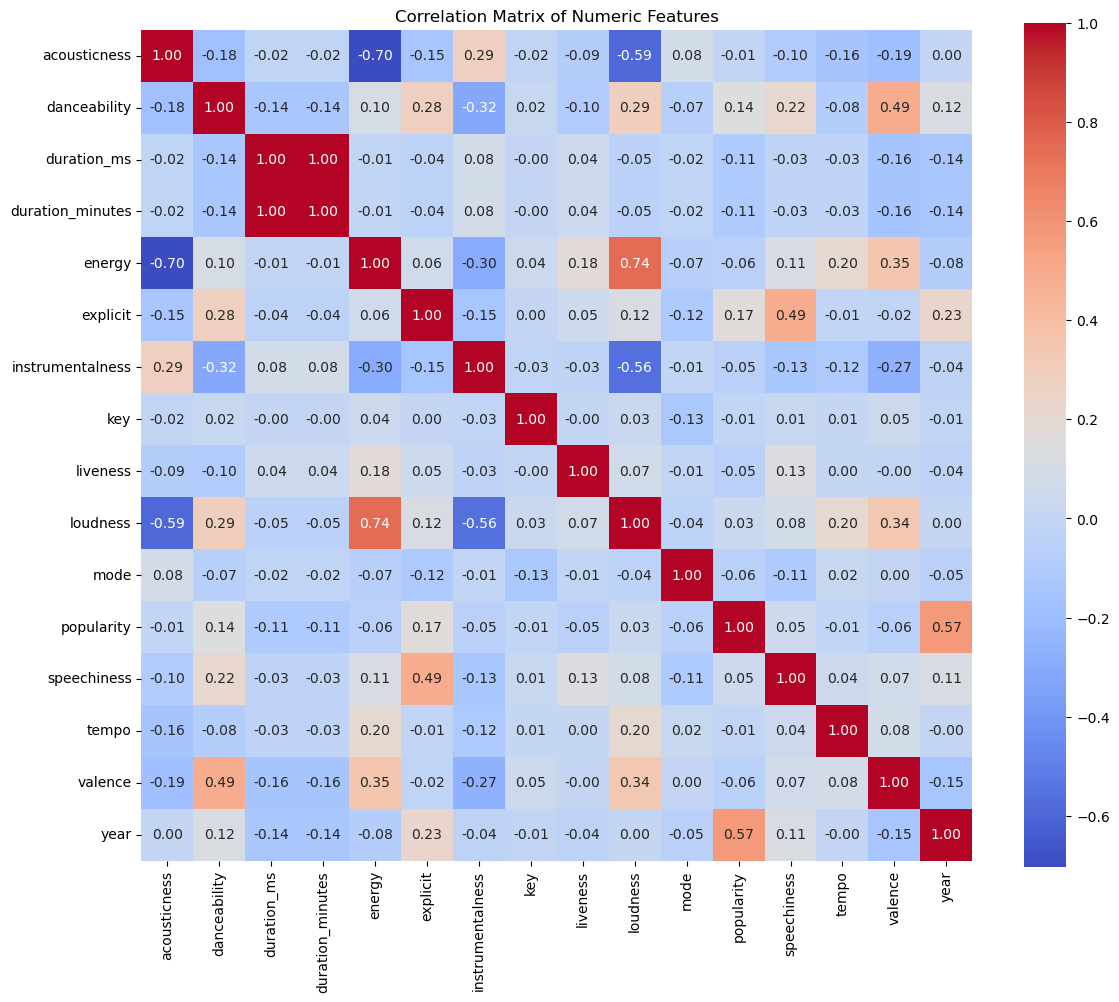

In [17]:
# Correlation heatmap for numeric features
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

### Observation:

- year shows a strong positive correlation with popularity (0.57), suggesting that newer songs are more likely to be popular, possibly due to Spotify’s growth and recency bias in listener behavior.

- The explicit flag has a mild positive correlation with both popularity (0.17) and danceability (0.28), hinting that explicit content has become more accepted or even desirable in popular music, particularly in genres like hip-hop or pop.

- These trends reflect possible shifts in listener preferences and industry practices, and they may influence how we model and interpret the popularity of songs across time.



Let’s begin exploring the popularity column to understand its distribution.

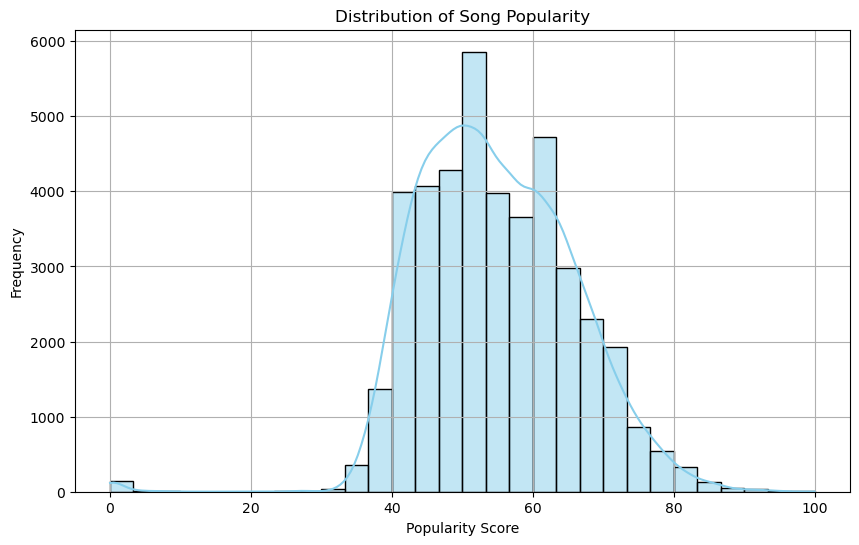

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot popularity distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['popularity'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Song Popularity')
plt.xlabel('Popularity Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Popularity Distribution Observation

- Popularity scores range from 0 to 100, but most songs fall between 40 and 70.

- The distribution is right-skewed, with a long tail toward higher popularity.

- Very few songs reach the 80+ range, making them strong candidates to be labeled as “hits.”

Based on this distribution, we will define hit songs as those with popularity > 80, roughly representing the top ~5–10% of tracks.



## Step 3: Define “Hit” Songs with a Binary Column

In [19]:
# Define hit as popularity > 80
df['is_hit'] = (df['popularity'] > 80).astype(int)

# Check distribution of hits vs non-hits
df['is_hit'].value_counts()

is_hit
0    41221
1      435
Name: count, dtype: int64

### Hit Song Threshold Observation

- Out of 41,656 songs, only 435 meet the criteria of a "hit" (popularity > 80).

- This represents approximately 1.04% of the dataset.

- The data is therefore highly imbalanced, and hit songs are rare events, which is typical in real-world applications like hit prediction or churn detection.

- This makes techniques like bootstrapping, resampling, and careful experiment design even more important.

## Step 4: Compute Basic Probabilities

In [20]:
# Basic probabilities
total_songs = len(df)
hit_songs = df['is_hit'].sum()
non_hit_songs = total_songs - hit_songs

p_hit = hit_songs / total_songs
p_non_hit = non_hit_songs / total_songs

print(f"P(Hit)       = {p_hit:.4f}")
print(f"P(Not Hit)   = {p_non_hit:.4f}")

P(Hit)       = 0.0104
P(Not Hit)   = 0.9896


### Basic Probability of a Hit

- The probability of randomly selecting a hit song from the dataset is P(Hit) = 0.0104 (≈1.04%).

- The probability of not selecting a hit is P(Not Hit) = 0.9896 (≈98.96%).

- This imbalance highlights how rare hits are in the overall Spotify music landscape — only about 1 in every 100 songs becomes a hit based on our definition.

- This forms a statistical baseline against which we’ll compare conditional probabilities and experimental effects later.

## Step 5: Conditional Probability – P(Hit | High Danceability)

In [21]:
# Find 75th percentile of danceability
danceability_threshold = df['danceability'].quantile(0.75)

# Create a flag for high danceability
df['high_danceability'] = (df['danceability'] > danceability_threshold).astype(int)

# Conditional probability: P(Hit | High Danceability)
p_hit_given_high_dance = (
    df[(df['is_hit'] == 1) & (df['high_danceability'] == 1)].shape[0] /
    df[df['high_danceability'] == 1].shape[0]
)

print(f"P(Hit | High Danceability) = {p_hit_given_high_dance:.4f}")

P(Hit | High Danceability) = 0.0217


### Observation

- We defined high danceability as songs in the top 25% of danceability scores.

- The probability of a song being a hit given it has high danceability is:
P(Hit | High Danceability) = 0.0217

- This is over twice the baseline hit probability of 0.0104.

- This suggests that highly danceable songs are more likely to be hits, although correlation does not imply causation — a proper hypothesis test or causal inference approach is needed to confirm this relationship.



## Step 6: P(Hit | High Valence)

In [22]:
# 75th percentile of valence
valence_threshold = df['valence'].quantile(0.75)

# High valence flag
df['high_valence'] = (df['valence'] > valence_threshold).astype(int)

# Conditional probability: P(Hit | High Valence)
p_hit_given_high_valence = (
    df[(df['is_hit'] == 1) & (df['high_valence'] == 1)].shape[0] /
    df[df['high_valence'] == 1].shape[0]
)

print(f"P(Hit | High Valence) = {p_hit_given_high_valence:.4f}")

P(Hit | High Valence) = 0.0099


### Observation
- We defined high valence as songs in the top 25% for valence (i.e., “happier” songs).

- The probability of a hit given high valence is:
P(Hit | High Valence) = 0.0099

- This is slightly below the baseline hit rate (0.0104), suggesting that high valence does not appear to increase the likelihood of a song being a hit.

- This may indicate that “happy” songs aren’t necessarily more successful on Spotify, at least not in isolation.

## Step 7: Average Popularity by Year

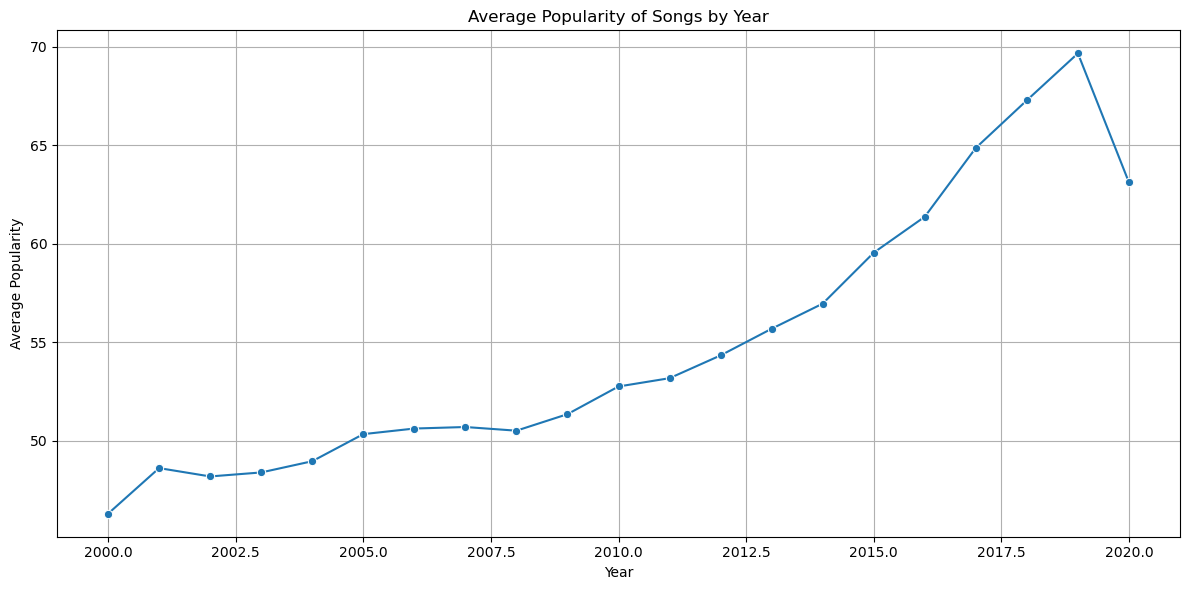

In [24]:
# Average popularity per year
popularity_by_year = df.groupby('year')['popularity'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=popularity_by_year, x='year', y='popularity', marker='o')
plt.title('Average Popularity of Songs by Year')
plt.xlabel('Year')
plt.ylabel('Average Popularity')
plt.grid(True)
plt.tight_layout()
plt.show()

- There is a clear upward trend in the average popularity of songs from 2000 to 2019.

- Popularity rose gradually until 2013, then accelerated sharply through the late 2010s, peaking in 2019.

- The drop in 2020 may reflect data collection limits, fewer tracks, or changing user behavior during the pandemic.

- This trend supports the earlier finding of a positive correlation between year and popularity (r = 0.57).

- This also suggests newer songs are more likely to be “hits” on the platform, possibly due to algorithmic promotion, growing user base, or cultural shifts.

## EDA Summary & Takeaways

**Key Findings:**
- The dataset contains 41,656 songs with rich audio features and metadata from 2000–2020.
- Only ~1% of songs are classified as "hits" (popularity > 80), making this a highly imbalanced problem.
- Hit probability is significantly higher among songs with high danceability (2.17%) compared to the baseline (1.04%).
- High valence ("happiness") does not significantly affect hit probability.
- Year has a strong positive correlation with popularity (0.57), and average song popularity has increased significantly over time.
- Explicit songs also show a slight positive relationship with popularity, indicating cultural or platform-level shifts.

**What’s Next:**
- In the next notebook, we will test hypotheses statistically:  
  → *Does high danceability cause a significant increase in hit likelihood?*  
  → *Can we simulate an A/B test for experimental design?*

We’ll move from correlation and conditional probability to **formal hypothesis testing and causal inference**.
